In [2]:
# functions to help you
import numpy as np
import scipy.sparse as spsp
from scipy.sparse.linalg import spsolve
import scipy.integrate as integrate

class Mesh:
    def __init__(self, points):
        # self.p    array with the node points (sorted) type : np.array dim: (n_p)
        # self.n_p  number of node points               type : int
        # self.s    array with indices of points per    type : np.array dim: (n_s, 2) 
        #           segment  
        # self.n_s  number of segments                  type : int
        # self.bc.  array with the indices of boundary  type : np.array dim: (2)
        #           points

        self.p   = np.sort(points)
        self.n_p = len(self.p)

        self.s   = np.column_stack((self.p[:-1], self.p[1:]))
        self.n_s = self.n_p - 1

        self.bc  = np.take(self.p, [0, -1])

In [3]:
class V_h:
    def __init__(self, mesh):
        # self.mesh Mesh object containg geometric info type: Mesh
        # self.sim  dimension of the space              type: in

        self.mesh = mesh
        self.dim  = mesh.n_p

    def eval(self, xi, x):
        """ evaluation of the piece wise local polynomial given by
           the coefficients xi, at the point x 
        """

        # compute the index of the interval in which x is contained
        points = self.mesh.p
        prev   = points[(points <= x)]
        idx    = np.minimum(len(prev)-1, self.mesh.n_s - 1)

        # compute the size of the interval
        interval = self.mesh.s[idx, :]
        seglen   = interval[1] - interval[0]

        return xi[idx] + (xi[idx + 1] - xi[idx]) / seglen * (x - interval[0]) # here return the value of the fucnciton 

In [4]:
class Function:
    def __init__(self, xi, v_h):
        self.xi  = xi
        self.v_h = v_h

    def __call__(self,x):
        # wrapper for calling eval in V_h

        # use the fucntion defined in v_h
        return V_h.eval(self.v_h, self.xi, x)

In [5]:
def mass_matrix(v_h):

    # sparse matrix easy to change sparsity pattern
    # this initializes an empty sparse matrix of 
    # size v_h.dim x v_h.dim
    M = spsp.lil_matrix((v_h.dim,v_h.dim))

    s = v_h.mesh.s
    
    # for loop
    for i in range(v_h.mesh.n_s):
        # extract the indices


        # compute the lengh of the segment
        h = s[i, 1] - s[i, 0]

        # add the values to the matrix
        M_temp = 1/6 * np.matrix([[2, 1], [1, 2]]) * h
        M[i, i] = M[i, i] + M_temp[0, 0]
        M[i, i+1] = M[i, i+1] + M_temp[0, 1]
        M[i+1, i] = M[i+1, i] + M_temp[1, 0]
        M[i+1, i+1] = M[i+1, i+1] + M_temp[1, 1]

    return M

In [6]:
def stiffness_matrix(v_h, sigma):

    # matrix easy to change sparsity pattern
    S = spsp.lil_matrix((v_h.dim,v_h.dim))

    s = v_h.mesh.s
    
    # for loop
    for i in range(v_h.mesh.n_s):
        # extract the indices


        # compute the lengh of the segment
        h = s[i, 1] - s[i, 0]

        # sample sigma
        sig = sigma((s[i, 0] + s[i, 1]) / 2)

        # update the stiffness matrix
        S_temp = sig / h * np.matrix([[1, -1], [-1, 1]])
        S[i, i] = S[i, i] + S_temp[0, 0]
        S[i, i+1] = S[i, i+1] + S_temp[0, 1]
        S[i+1, i] = S[i+1, i] + S_temp[1, 0]
        S[i+1, i+1] = S[i+1, i+1] + S_temp[1, 1]

    return S

In [7]:
# show differences between Trapezoidal rule and Simpson rule
def load_vector(v_h, f):

    # allocate the vector
    b = np.zeros(v_h.dim)

    s = v_h.mesh.s
    
    # for loop over the segments
    for i in range(v_h.mesh.n_s):
        # extracting the indices


        # computing the lenght of the interval 
        h = s[i, 1] - s[i, 0]

        # update b
        b[i] = b[i] + 1/2 * f(s[i, 0]) *h
        b[i+1] = b[i+1] + 1/2 * f(s[i, 1]) *h

    return b

In [8]:
def source_assembler(v_h, f, sigma, u_dirichlet):
    # computing the load vector (use the function above)
    load_vector(v_h, f)
    
    s = v_h.mesh.s
    b = load_vector(v_h, f)
    
    # extract the interval index for left boundary


    # compute the lenght of the interval
    h_1 = s[0, 1] - s[0, 0]

    # sample sigma at the middle point
    sig_1 = sigma((s[0, 0] + s[0, 1]) / 2)

    # update the source_vector
    b[1] = b[1] + sig_1 / h_1 * u_dirichlet[0]


    # extract the interval index for the right boudanry



    # compute the length of the interval
    h_n = s[-1, 1] - s[-1, 0]


    # sample sigma at the middle point
    sig_n = sigma((s[-1, 0] + s[-1, 1]) / 2)


    # update the source_vector
    b[-2] = b[-2] + sig_n / h_n * u_dirichlet[1]
    
    # return only the interior nodes
    return b[1:-1]

In [9]:
def solve_poisson_dirichelet(v_h, f, sigma, 
                             u_dirichlet=np.zeros((2)) ):
    """ function to solbe the Poisson equation with 
    Dirichlet boundary conditions
    input:  v_h         function space
          f           load (python function)
          sigma       conductivity
          u_dirichlet boundary conditions
    output: u           approximation (Function class)
    """  

    # we compute the stiffness matrix, we only use the  
    # the interior dof, and we need to convert it to 
    # a csc_matrix
    S = stiffness_matrix(v_h, sigma)[1:-1, 1:-1]

    # we build the source
    b = source_assembler(v_h, f, sigma, u_dirichlet)

    # solve for the interior degrees of freedom
    u_interior = spsolve(S,b)

    # concatenate the solution to add the boundary 
    # conditions
    xi_u = np.concatenate([u_dirichlet[:1], 
                         u_interior, 
                         u_dirichlet[1:]])

    # return the function
    return Function(xi_u, v_h)

In [10]:
def pi_h(v_h, f):
    """interpolation function
    input:  v_h   function space
            f     function to project
    output: pih_f function that is the interpolation 
                  of f into v_h
    """
    pi_h_f = Function(f, v_h)


    return pi_h_f

In [11]:
def p_h(v_h, f):
    """projection function
    input:  v_h   function space
            f     function to project
    output: ph_f  function that is the projection 
                  of f into v_h
    """
    # compute load vector
    b = load_vector(v_h, f)

    # compute Mass matrix and convert it to csc type
    M = mass_matrix(v_h)

    # solve the system
    xi = spsolve(M,b)

    # create the new function (this needs to be an instance)
    # of a Function class
    ph_f = Function(xi, v_h)

    return ph_f

In [12]:
if __name__ == "__main__":

    """ This is the main function, which will run 
    if you try to run this script, this code was provided 
    to you to help you debug your code. 
    """ 

    x = np.linspace(0,1,11)

    mesh = Mesh(x)
    v_h  = V_h(mesh)


    f_load = lambda x: 2+0*x
    xi = f_load(x) # linear function

    u = Function(xi, v_h) 

    assert np.abs(u(x[5]) - f_load(x[5])) < 1.e-6

    # check if this is projection
    ph_f = p_h(v_h, f_load)
    ph_f2 = p_h(v_h, ph_f)

    # 
    assert np.max(ph_f.xi - ph_f2.xi) < 1.e-6

    # using analytical solution
    u = lambda x : np.sin(4*np.pi*x)
    # building the correct source file
    f = lambda x : (4*np.pi)**2*np.sin(4*np.pi*x)
    # conductivity is constant
    sigma = lambda x : 1 + 0*x  

    u_sol = solve_poisson_dirichelet(v_h, f, sigma)

    err = lambda x: np.square(u_sol(x) - u(x))
    # we use an fearly accurate quadrature 
    l2_err = np.sqrt(integrate.quad(err, 0.0,1.)[0])

    print("L^2 error using %d points is %.6f"% (v_h.dim, l2_err))
    # this should be quite large

    # define a finer partition 
    x = np.linspace(0,1,21)
    # init mesh and fucntion space
    mesh = Mesh(x)
    v_h  = V_h(mesh)

    u_sol = solve_poisson_dirichelet(v_h, f, sigma)

    err = lambda x: np.square(u_sol(x) - u(x))
    # we use an fearly accurate quadrature 
    l2_err = np.sqrt(integrate.quad(err, 0.0,1.)[0])

    # print the error
    print("L^2 error using %d points is %.6f"% (v_h.dim, l2_err))

L^2 error using 11 points is 0.049821
L^2 error using 21 points is 0.010890


/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
<ipython-input-12-db64e2a5bc61>:39: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  l2_err = np.sqrt(integrate.quad(err, 0.0,1.)[0])
<ipython-input-12-db64e2a5bc61>:54: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficult

/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
<ipython-input-13-4ded452a1f8c>:23: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  l2_err[i] = np.sqrt(integrate.quad(err, 0.0,1.)[0])


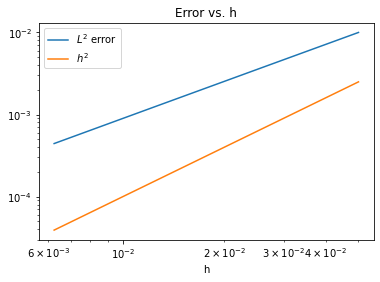

In [13]:
#B1
import matplotlib.pyplot as plt

f = lambda x : np.exp(x)

rounds = 4
l2_err = np.empty([rounds, 1])
h      = np.empty([rounds, 1])

for i in range(rounds):

    # define a partition 
    x    = np.linspace(0,1,20*2**i+1)
    h[i] = (x[-1] - x[0]) / (len(x) - 1)
    # init mesh and fucntion space
    mesh = Mesh(x)
    v_h  = V_h(mesh)

    f_sol = p_h(v_h, f)

    err = lambda x: np.square(f_sol(x) - f(x))
    # we use an fearly accurate quadrature 
    l2_err[i] = np.sqrt(integrate.quad(err, 0.0,1.)[0])

plt.loglog(h, l2_err)
plt.loglog(h, h**2)
plt.xlabel('h')
plt.title('Error vs. h')
plt.legend(['$L^2$ error', '$h^2$'])


/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
<ipython-input-14-72014cf9b3e3>:22: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  l2_err[i] = np.sqrt(integrate.quad(err, 0.0,1.)[0])


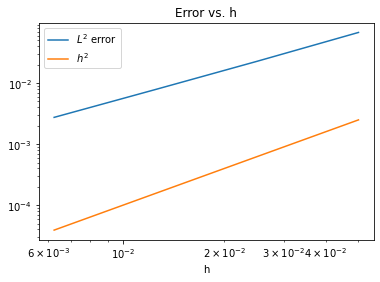

In [14]:
#B2

f = lambda x : np.sin(4*np.pi*x)

rounds = 4
l2_err = np.empty([rounds, 1])
h      = np.empty([rounds, 1])

for i in range(rounds):

    # define a partition 
    x    = np.linspace(0,1,20*2**i+1)
    h[i] = (x[-1] - x[0]) / (len(x) - 1)
    # init mesh and fucntion space
    mesh = Mesh(x)
    v_h  = V_h(mesh)

    f_sol = p_h(v_h, f)

    err = lambda x: np.square(f_sol(x) - f(x))
    # we use an fearly accurate quadrature 
    l2_err[i] = np.sqrt(integrate.quad(err, 0.0,1.)[0])

plt.loglog(h, l2_err)
plt.loglog(h, h**2)
plt.xlabel('h')
plt.title('Error vs. h')
plt.legend(['$L^2$ error', '$h^2$'])

/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
<ipython-input-15-beaa086d6df3>:22: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  l2_err[i] = np.sqrt(integrate.quad(err, 0.0,1.)[0])


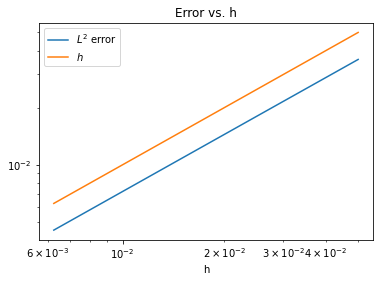

In [15]:
#B3

f = lambda x : np.sqrt(1-x**2)

rounds = 4
l2_err = np.empty([rounds, 1])
h      = np.empty([rounds, 1])

for i in range(rounds):

    # define a partition 
    x    = np.linspace(0,1,20*2**i+1)
    h[i] = (x[-1] - x[0]) / (len(x) - 1)
    # init mesh and fucntion space
    mesh = Mesh(x)
    v_h  = V_h(mesh)

    f_sol = p_h(v_h, f)

    err = lambda x: np.square(f_sol(x) - f(x))
    # we use an fearly accurate quadrature 
    l2_err[i] = np.sqrt(integrate.quad(err, 0.0,1.)[0])

plt.loglog(h, l2_err)
plt.loglog(h, h)
plt.xlabel('h')
plt.title('Error vs. h')
plt.legend(['$L^2$ error', '$h$'])

/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
<ipython-input-28-663ac06ceccb>:29: RuntimeWarning: invalid value encountered in sqrt
  l2_err[i] = np.sqrt(integrate.quad(err_diff, 0.0,1.)[0])


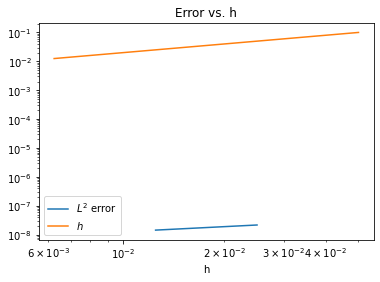

In [28]:
#C(a)
import sympy as sym

# using analytical solution
u = lambda x : np.sin(4*np.pi*x)
# building the correct source file
f = lambda x : (4*np.pi)**2*np.sin(4*np.pi*x)
# conductivity is constant
sigma = lambda x : 1 + 0*x 

rounds = 4
l2_err = np.empty([rounds, 1])
h      = np.empty([rounds, 1])

for i in range(rounds):

    # define a partition 
    x    = np.linspace(0,1,20*2**i+1)
    h[i] = (x[-1] - x[0]) / (len(x) - 1)
    # init mesh and fucntion space
    mesh = Mesh(x)
    v_h  = V_h(mesh)

    u_sol = solve_poisson_dirichelet(v_h, f, sigma)

    err = lambda x: np.square(u_sol(x) - u(x))
    err_diff = lambda x: (err(x+0.001) - err(x-0.001)) / 0.02
    # we use an fearly accurate quadrature 
    l2_err[i] = np.sqrt(integrate.quad(err_diff, 0.0,1.)[0])

plt.loglog(h, l2_err)
plt.loglog(h, h*2)
plt.xlabel('h')
plt.title('Error vs. h')
plt.legend(['$L^2$ error', '$h$'])

In [39]:
#E(e)

def solve_E(v_h, f, sigma, u_dirichlet=np.zeros((2)) ):

    S = stiffness_matrix(v_h, sigma)[1:-1, 1:-1]
    M = mass_matrix(v_h)[1:-1, 1:-1]

    # we build the source
    b = source_assembler(v_h, f, sigma, u_dirichlet)

    # solve for the interior degrees of freedom
    u_interior = spsolve(S+M,b)

    # concatenate the solution to add the boundary 
    # conditions
    xi_u = np.concatenate([u_dirichlet[:1], 
                         u_interior, 
                         u_dirichlet[1:]])

    # return the function
    return Function(xi_u, v_h)

<ipython-input-42-8e1e8efc7293>:27: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  l2_err[i] = np.sqrt(integrate.quad(err, 0.0,1.)[0])


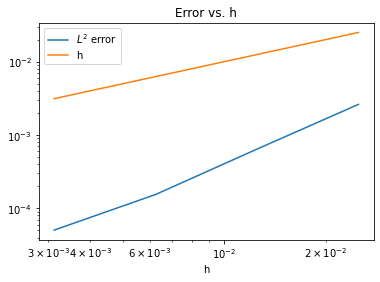

In [42]:
#E(f)

# using analytical solution
u = lambda x : np.sin(4*np.pi*x)
# building the correct source file
f = lambda x : ((4*np.pi)**2+1)*np.sin(4*np.pi*x)
# conductivity is constant
sigma = lambda x : 1 + 0*x 

rounds = 4
l2_err = np.empty([rounds, 1])
h      = np.empty([rounds, 1])

for i in range(rounds):

    # define a partition 
    x    = np.linspace(0,1,40*2**i+1)
    h[i] = (x[-1] - x[0]) / (len(x) - 1)
    # init mesh and fucntion space
    mesh = Mesh(x)
    v_h  = V_h(mesh)

    u_sol = solve_E(v_h, f, sigma)

    err = lambda x: np.square(u_sol(x) - u(x))
    # we use an fearly accurate quadrature 
    l2_err[i] = np.sqrt(integrate.quad(err, 0.0,1.)[0])

plt.loglog(h, l2_err)
plt.loglog(h, h)
plt.xlabel('h')
plt.title('Error vs. h')
plt.legend(['$L^2$ error', 'h'])